In [2]:
# NBVAL_SKIP
from rubix.telescope.filters.filters import load_filter

curves = load_filter("SLOAN")

In [3]:
curves

FilterCurves(
  filters=[
    Filter(
      wavelength=f32[1043],
      response=f32[1043],
      name='SLOAN/SDSS.uprime_filter'
    ),
    Filter(wavelength=f32[47], response=f32[47], name='SLOAN/SDSS.u'),
    Filter(wavelength=f32[89], response=f32[89], name='SLOAN/SDSS.g'),
    Filter(
      wavelength=f32[2229],
      response=f32[2229],
      name='SLOAN/SDSS.gprime_filter'
    ),
    Filter(wavelength=f32[75], response=f32[75], name='SLOAN/SDSS.r'),
    Filter(
      wavelength=f32[2008],
      response=f32[2008],
      name='SLOAN/SDSS.rprime_filter'
    ),
    Filter(wavelength=f32[89], response=f32[89], name='SLOAN/SDSS.i'),
    Filter(
      wavelength=f32[2333],
      response=f32[2333],
      name='SLOAN/SDSS.iprime_filter'
    ),
    Filter(wavelength=f32[141], response=f32[141], name='SLOAN/SDSS.z'),
    Filter(
      wavelength=f32[5644],
      response=f32[5644],
      name='SLOAN/SDSS.zprime_filter'
    )
  ]
)

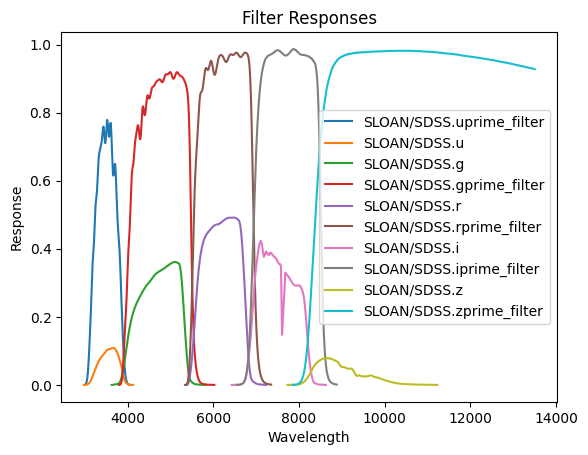

In [4]:
# NBVAL_SKIP
curves.plot()

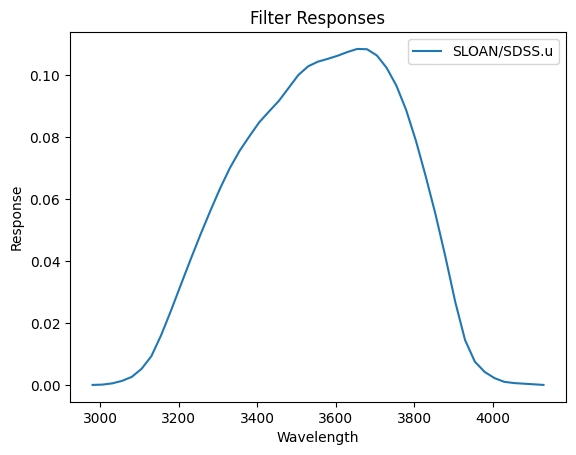

In [6]:
# NBVAL_SKIP
filter = curves[1]
filter.plot()

In [ ]:
# NBVAL_SKIP
# here goes the loading of a dummy galaxy data cube. so we can test convolve with the filter

In [8]:
# NBVAL_SKIP
from rubix.telescope.filters.filters import convolve_filter_with_spectra

In [9]:
# NBVAL_SKIP
#convolved = convolve_filter_with_spectra(filter, cube, wave)
#print(convolved.shape)

NameError: name 'cube' is not defined

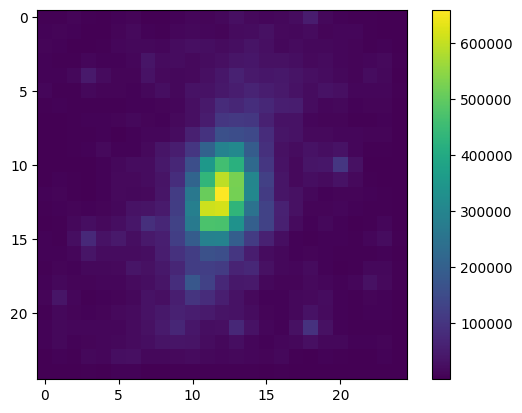

In [7]:
# NBVAL_SKIP
#import matplotlib.pyplot as plt
#plt.imshow(convolved)
#plt.colorbar()

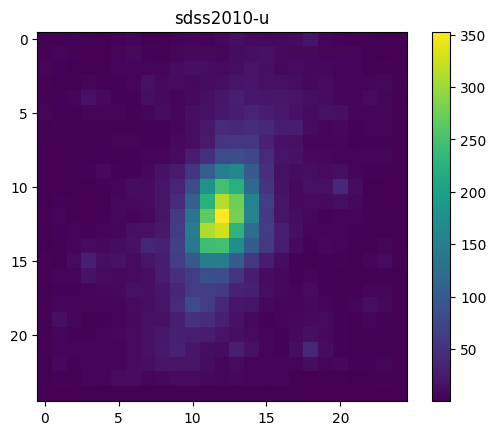

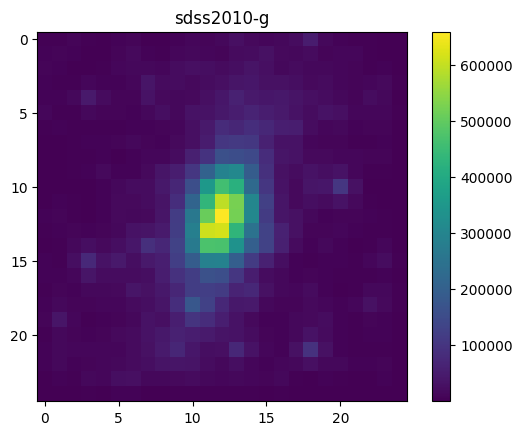

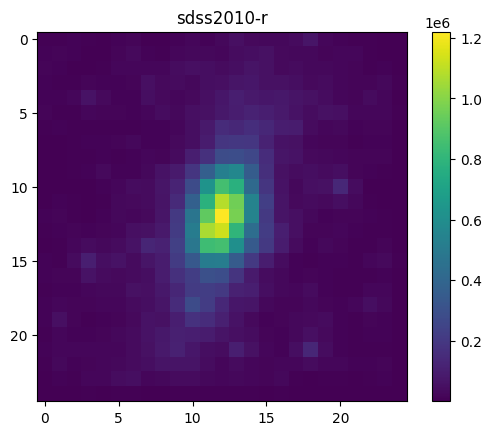

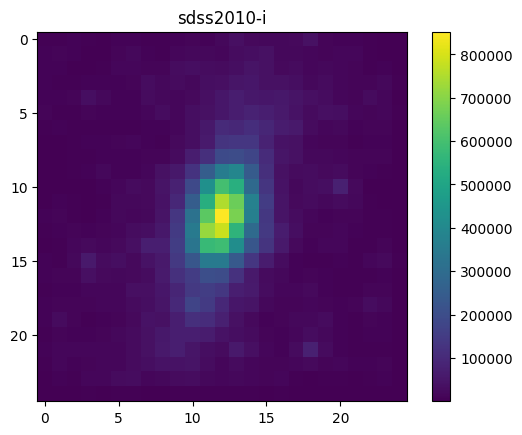

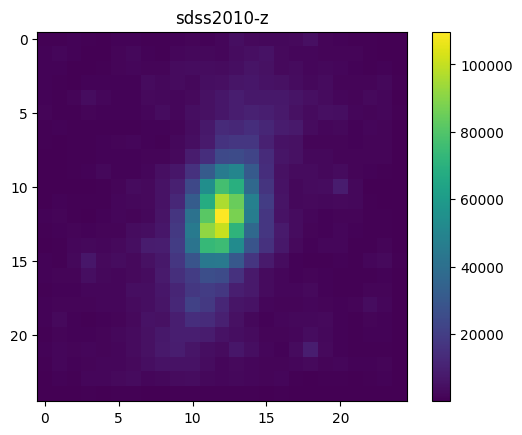

In [8]:
# NBVAL_SKIP
for filter in curves:
    convolved = convolve_filter_with_spectra(filter, cube, wave)
    plt.figure()
    plt.imshow(convolved)
    plt.colorbar()
    plt.title(filter.name)

In [9]:
# NBVAL_SKIP
filters,images =curves.apply_filter_curves(cube, wave).values()

In [10]:
# NBVAL_SKIP
filters

['sdss2010-u', 'sdss2010-g', 'sdss2010-r', 'sdss2010-i', 'sdss2010-z']

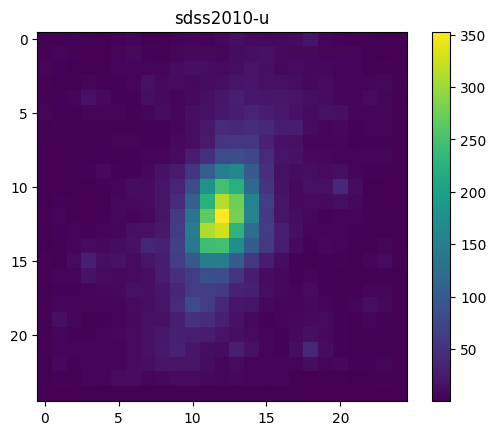

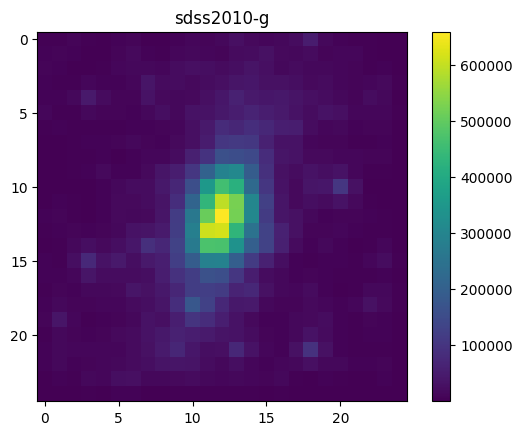

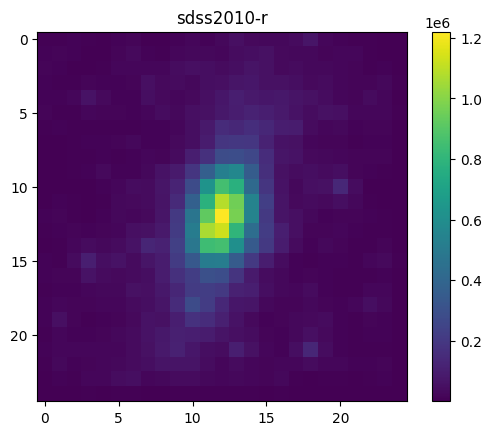

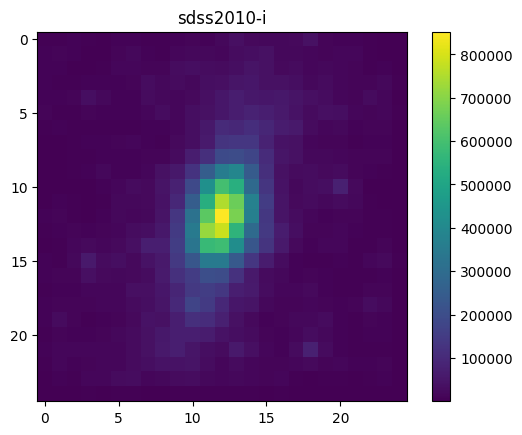

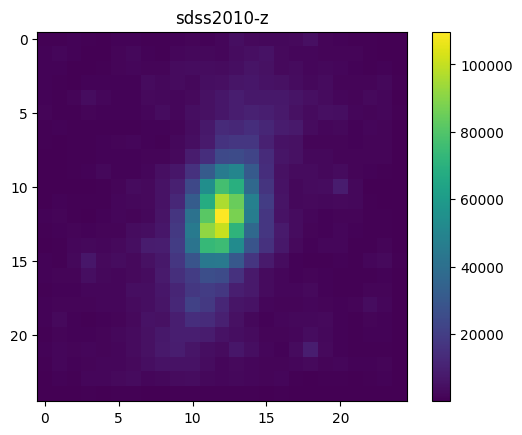

In [11]:
# NBVAL_SKIP
for i,name in zip(images, filters):
    plt.figure()
    plt.imshow(i)
    plt.colorbar()
    plt.title(name)

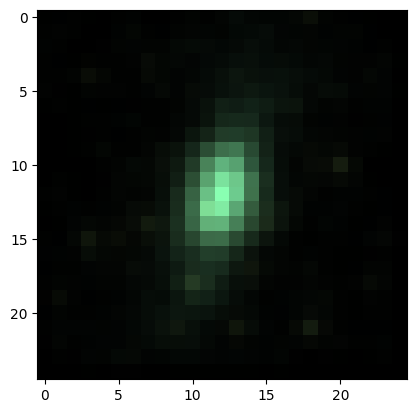

In [12]:
# NBVAL_SKIP
# Create an RGB image
# Normalize the images
def normalize(image):
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) / (image_max - image_min)

r = images[1]
g = images[2]
b = images[3]

rgb = np.stack([r,g,b], axis=-1)

rgb = normalize(rgb)

plt.imshow(rgb)

